In [ ]:
# pip install imbalanced-learn

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')
import xgboost as xgb
from sklearn.calibration import CalibratedClassifierCV
from sklearn.metrics import classification_report, roc_auc_score, roc_curve, auc, accuracy_score, confusion_matrix
from sklearn.preprocessing import label_binarize, StandardScaler, LabelEncoder
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV, RandomizedSearchCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import make_pipeline
from sklearn.neighbors import KNeighborsClassifier
from imblearn.under_sampling import RandomUnderSampler
from imblearn.over_sampling import SMOTE
from imblearn.pipeline import Pipeline
from collections import Counter
from IPython.display import display, HTML



In [2]:
# Load data
data = pd.read_csv('augmented_file_50x.csv')

In [ ]:
data['label'].value_counts()

In [ ]:
data.describe()

In [ ]:
# Visualizing the data distribution between temperature, ph and rainfall

plt.figure(figsize=(12,5))
plt.subplot(1, 3, 1)
sns.distplot(data['temperature'],color="red",bins=15,hist_kws={'alpha':0.2})
plt.subplot(1, 3, 2)
sns.distplot(data['ph'],color="blue",bins=15,hist_kws={'alpha':0.2})
plt.subplot(1, 3, 3)
sns.distplot(data['rainfall'],color="green",bins=15,hist_kws={'alpha':0.2})


In [ ]:
# Visualizing the data distribution between N, P, and K

plt.figure(figsize=(18,6))
plt.subplot(1, 3, 1)
sns.distplot(data['N'],color="red",bins=15,hist_kws={'alpha':0.2})
plt.subplot(1, 3, 2)
sns.distplot(data['P'],color="blue",bins=15,hist_kws={'alpha':0.2})
plt.subplot(1, 3, 3)
sns.distplot(data['K'],color="green",bins=15,hist_kws={'alpha':0.2})

In [3]:

# Split data into features and labels
X = data.drop('label', axis=1)
y = data['label']

# Lists to collect split data
X_train_list = []
X_val_list = []
X_test_list = []
y_train_list = []
y_val_list = []
y_test_list = []

# Split each label's data separately
labels = y.unique()
for label in labels:
    X_label = X[y == label]
    y_label = y[y == label]
    
    # First, separate out the training data (70%)
    X_train_label, X_temp_label, y_train_label, y_temp_label = train_test_split(
        X_label, y_label, test_size=0.30, random_state=0)
    
    # Now, split the remaining data into validation and test sets (20% test, 10% validation)
    X_test_label, X_val_label, y_test_label, y_val_label = train_test_split(
        X_temp_label, y_temp_label, test_size=0.3333, random_state=0)
    
    X_train_list.append(X_train_label)
    X_val_list.append(X_val_label)
    X_test_list.append(X_test_label)
    y_train_list.append(y_train_label)
    y_val_list.append(y_val_label)
    y_test_list.append(y_test_label)

# Concatenate splits
X_train = pd.concat(X_train_list, axis=0)
y_train = pd.concat(y_train_list, axis=0)
X_val = pd.concat(X_val_list, axis=0)
y_val = pd.concat(y_val_list, axis=0)
X_test = pd.concat(X_test_list, axis=0)
y_test = pd.concat(y_test_list, axis=0)

print("Training set size:", len(X_train))
print("Validation set size:", len(X_val))
print("Testing set size:", len(X_test))


Training set size: 77000
Validation set size: 11000
Testing set size: 22000


Cross-validated accuracy scores for each fold: [0.9487013  0.95532468 0.95974026 0.9538961  0.95012987 0.94987013
 0.94935065 0.94974026 0.95233766 0.94753247]
Mean CV Accuracy: 0.9516623376623375
Standard Deviation of CV Accuracy: 0.003528932532225746
Calibrated Random Forest Validation accuracy: 0.9663636363636363
Calibrated Random Forest Test accuracy: 0.9669545454545454
Calibrated Random Forest Test Classification Report:
              precision    recall  f1-score   support

       apple       1.00      1.00      1.00      1000
      banana       1.00      1.00      1.00      1000
   blackgram       0.99      0.99      0.99      1000
    chickpea       1.00      1.00      1.00      1000
     coconut       1.00      0.96      0.98      1000
      coffee       1.00      1.00      1.00      1000
      cotton       1.00      1.00      1.00      1000
      grapes       1.00      1.00      1.00      1000
        jute       0.89      0.42      0.58      1000
 kidneybeans       1.00      

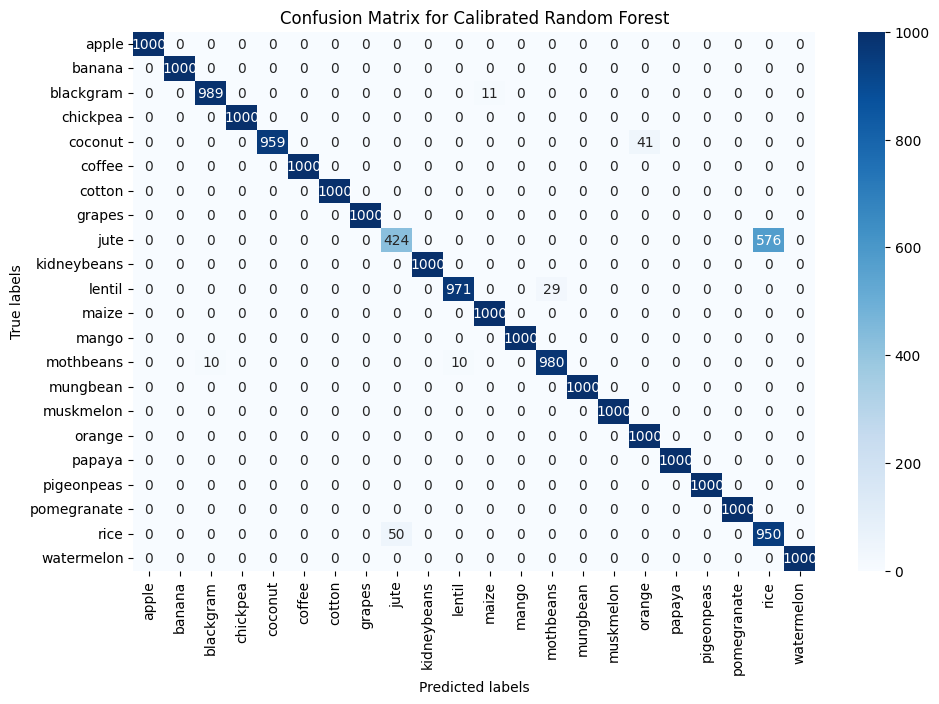

In [4]:
# Using 'auto' strategy for RandomUnderSampler
under = RandomUnderSampler(sampling_strategy='auto')
X_resampled, y_resampled = under.fit_resample(X_train, y_train)

# Train the Random Forest on the resampled data
clf_rf = RandomForestClassifier(n_estimators=100, max_depth=6, max_features=4, random_state=0)
clf_rf.fit(X_resampled, y_resampled)

# Perform 10-fold cross-validation on the resampled data
cv_scores = cross_val_score(clf_rf, X_resampled, y_resampled, cv=10, scoring='accuracy')

# Print out the scores for each fold and average accuracy
print("Cross-validated accuracy scores for each fold:", cv_scores)
print("Mean CV Accuracy:", cv_scores.mean())
print("Standard Deviation of CV Accuracy:", cv_scores.std())

# Calibrate the classifier on the validation set
calibrated_rf = CalibratedClassifierCV(clf_rf, method='sigmoid', cv='prefit')
calibrated_rf.fit(X_val, y_val)

# Predict on the validation set using the calibrated RF
y_pred_val = calibrated_rf.predict(X_val)
accuracy_score_val = accuracy_score(y_val, y_pred_val)
print("Calibrated Random Forest Validation accuracy:", accuracy_score_val)

# Predict on the test set using the calibrated RF
y_pred_calibrated = calibrated_rf.predict(X_test)
accuracy_score_rf = accuracy_score(y_test, y_pred_calibrated)
print("Calibrated Random Forest Test accuracy:", accuracy_score_rf)
print("Calibrated Random Forest Test Classification Report:")
print(classification_report(y_test, y_pred_calibrated))

# Compute the confusion matrix for calibrated RF
conf_mat_calibrated = confusion_matrix(y_test, y_pred_calibrated)
class_labels = np.unique(y_test)

# Plot using Seaborn for calibrated RF
plt.figure(figsize=(11,7))
sns.heatmap(conf_mat_calibrated, annot=True, fmt="d", cmap='Blues', xticklabels=class_labels, yticklabels=class_labels)
plt.xlabel('Predicted labels')
plt.ylabel('True labels')
plt.title('Confusion Matrix for Calibrated Random Forest')
plt.show()


Cross-validated accuracy scores for each fold (KNN): [0.95636364 0.95454545 0.95454545 0.95857143 0.95519481 0.95519481
 0.95831169 0.95519481 0.95727273 0.95506494]
Mean CV Accuracy (KNN): 0.9560259740259742
Standard Deviation of CV Accuracy (KNN): 0.001440563597284364
K-nearest Neighbors Validation accuracy: 0.9567272727272728
K-nearest Neighbors Test accuracy: 0.9570454545454545
K-nearest Neighbors Test Classification Report:
              precision    recall  f1-score   support

       apple       0.88      1.00      0.94      1000
      banana       1.00      1.00      1.00      1000
   blackgram       0.89      0.99      0.94      1000
    chickpea       1.00      1.00      1.00      1000
     coconut       0.98      1.00      0.99      1000
      coffee       1.00      1.00      1.00      1000
      cotton       1.00      1.00      1.00      1000
      grapes       1.00      0.87      0.93      1000
        jute       0.79      1.00      0.88      1000
 kidneybeans       0.92   

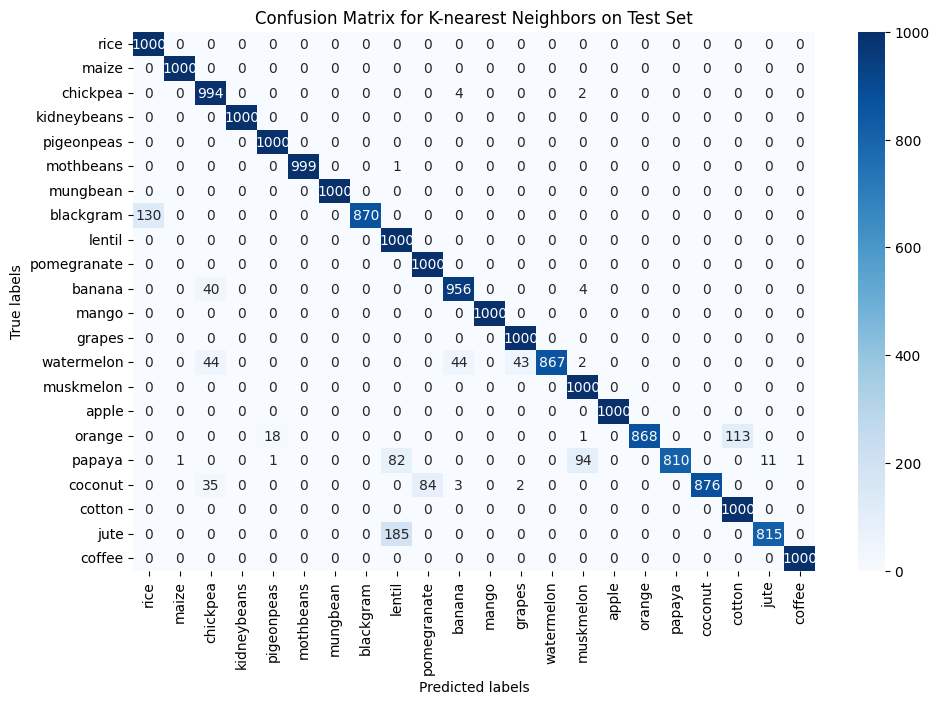

In [6]:
# Feature Scaling
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_val_scaled = scaler.transform(X_val) # scale the validation set
X_test_scaled = scaler.transform(X_test)

# Using 'auto' strategy for RandomUnderSampler
under = RandomUnderSampler(sampling_strategy='auto')

# Apply the undersampling strategy
X_train_resampled, y_train_resampled = under.fit_resample(X_train_scaled, y_train)

# Define the K-nearest neighbors (KNN) classifier with adjusted parameters
clf_knn = KNeighborsClassifier(n_neighbors=5001, weights='distance', algorithm='auto', p=2)

# Fit the KNN model with resampled training data
clf_knn.fit(X_train_resampled, y_train_resampled)

# Perform 10-fold cross-validation on the resampled data
cv_scores_knn = cross_val_score(clf_knn, X_train_resampled, y_train_resampled, cv=10, scoring='accuracy')

# Print out the scores for each fold and average accuracy
print("Cross-validated accuracy scores for each fold (KNN):", cv_scores_knn)
print("Mean CV Accuracy (KNN):", cv_scores_knn.mean())
print("Standard Deviation of CV Accuracy (KNN):", cv_scores_knn.std())

# Predict using the KNN model on the scaled validation set
y_pred_knn_val = clf_knn.predict(X_val_scaled)
accuracy_score_knn_val = accuracy_score(y_val, y_pred_knn_val)
print("K-nearest Neighbors Validation accuracy:", accuracy_score_knn_val)


# Predict using the KNN model on the scaled test set
y_pred_knn = clf_knn.predict(X_test_scaled)
accuracy_score_knn = accuracy_score(y_test, y_pred_knn)
print("K-nearest Neighbors Test accuracy:", accuracy_score_knn)
print("K-nearest Neighbors Test Classification Report:")
print(classification_report(y_test, y_pred_knn))

# Compute the confusion matrix for test set
conf_mat_knn = confusion_matrix(y_test, y_pred_knn)

# Extract unique class labels
class_labels = data['label'].unique()

# Plot using Seaborn
plt.figure(figsize=(11,7))
sns.heatmap(conf_mat_knn, annot=True, fmt="d", cmap='Blues', xticklabels=class_labels, yticklabels=class_labels)
plt.xlabel('Predicted labels')
plt.ylabel('True labels')
plt.title('Confusion Matrix for K-nearest Neighbors on Test Set')
plt.show()


In [7]:

# Set up the RandomUnderSampler
under = RandomUnderSampler(sampling_strategy='auto')
X_train_under, y_train_under = under.fit_resample(X_train, y_train)

# Set var_smoothing parameter for regularization
var_smoothing_value = 1e-1
clf_nb = GaussianNB(var_smoothing=var_smoothing_value)

# Perform 10-fold cross-validation on undersampled data
cv_scores = cross_val_score(clf_nb, X_train_under, y_train_under, cv=10, scoring='accuracy')

# Print out the scores for each fold and average accuracy
print("Cross-validated accuracy scores for each fold:", cv_scores)
print("Mean CV Accuracy:", cv_scores.mean())
print("Standard Deviation of CV Accuracy:", cv_scores.std())

# Fit the clf_nb with the undersampled training data
clf_nb.fit(X_train_under, y_train_under)

# Calibrate the classifier
calibrated_nb = CalibratedClassifierCV(clf_nb, method='sigmoid', cv='prefit')
calibrated_nb.fit(X_val, y_val)

# Predict for the training set using the calibrated model
y_pred_nb_train = calibrated_nb.predict(X_train)
accuracy_score_nb_train = accuracy_score(y_train, y_pred_nb_train)

# Predict for the validation set using the calibrated model
y_pred_nb_val = calibrated_nb.predict(X_val)
accuracy_score_nb_val = accuracy_score(y_val, y_pred_nb_val)

# Predict for the test set using the calibrated model
y_pred_nb = calibrated_nb.predict(X_test)
accuracy_score_nb = accuracy_score(y_test, y_pred_nb)

print("\nNaive Bayes Train accuracy:", accuracy_score_nb_train)
print("Naive Bayes Validation accuracy:", accuracy_score_nb_val)
print("\nNaive Bayes Test accuracy:", accuracy_score_nb)
print("Naive Bayes Test Classification Report:")
print(classification_report(y_test, y_pred_nb))

# Compute the confusion matrix for the test set
conf_mat_nb = confusion_matrix(y_test, y_pred_nb)

# Extract unique class labels
class_labels = np.unique(y)

# Plot using Seaborn for the test set
plt.figure(figsize=(11,7))
sns.heatmap(conf_mat_nb, annot=True, fmt="d", cmap='Blues', xticklabels=class_labels, yticklabels=class_labels)
plt.xlabel('Predicted labels')
plt.ylabel('True labels')
plt.title('Confusion Matrix for Naive Bayes on Test Set')
plt.show()



Cross-validated accuracy scores for each fold: [0.9587013  0.95714286 0.96064935 0.95402597 0.95805195 0.95805195
 0.96337662 0.95766234 0.9574026  0.95948052]
Mean CV Accuracy: 0.9584545454545456
Standard Deviation of CV Accuracy: 0.002314058321068734

Naive Bayes Train accuracy: 0.9774675324675325
Naive Bayes Validation accuracy: 0.9763636363636363

Naive Bayes Test accuracy: 0.9760454545454545
Naive Bayes Test Classification Report:
              precision    recall  f1-score   support

       apple       1.00      1.00      1.00      1000
      banana       1.00      1.00      1.00      1000
   blackgram       0.94      0.97      0.96      1000
    chickpea       1.00      1.00      1.00      1000
     coconut       1.00      1.00      1.00      1000
      coffee       0.99      0.99      0.99      1000
      cotton       1.00      1.00      1.00      1000
      grapes       1.00      1.00      1.00      1000
        jute       0.83      0.95      0.88      1000
 kidneybeans       

In [ ]:
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

# Scaling the features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_val_scaled = scaler.transform(X_val)
X_test_scaled = scaler.transform(X_test)

# Logistic Regression with stronger regularization (smaller C value)
clf_lr = LogisticRegression(C=0.001, max_iter=5000, random_state=0)
clf_lr.fit(X_train_scaled, y_train)

# Perform 10-fold cross-validation on the training data
cv_scores = cross_val_score(clf_lr, X_train_scaled, y_train, cv=10, scoring='accuracy')

# Print out the scores for each fold and average accuracy
print("Cross-validated accuracy scores for each fold:", cv_scores)
print("Mean CV Accuracy:", cv_scores.mean())
print("Standard Deviation of CV Accuracy:", cv_scores.std())

# Predict on the validation set
y_pred_lr_val = clf_lr.predict(X_val_scaled)
accuracy_score_lr_val = accuracy_score(y_val, y_pred_lr_val)

# Print the Logistic Regression Classification Report for the validation set
print("\nLogistic Regression Validation accuracy:", accuracy_score_lr_val)
print("Logistic Regression Validation Classification Report:")
print(classification_report(y_val, y_pred_lr_val))

# Predict on the test set
y_pred_lr = clf_lr.predict(X_test_scaled)
accuracy_score_lr = accuracy_score(y_test, y_pred_lr)

# Print the Logistic Regression Classification Report for the test set
print("\nLogistic Regression Test accuracy:", accuracy_score_lr)
print("Logistic Regression Test Classification Report:")
print(classification_report(y_test, y_pred_lr))

# Compute the confusion matrix for the test set
conf_mat_lr = confusion_matrix(y_test, y_pred_lr)

# Extract unique class labels
class_labels = np.unique(y)

# Plot using Seaborn for the test set
plt.figure(figsize=(11,7))
sns.heatmap(conf_mat_lr, annot=True, fmt="d", cmap='Blues', xticklabels=class_labels, yticklabels=class_labels)
plt.xlabel('Predicted labels')
plt.ylabel('True labels')
plt.title('Confusion Matrix for Logistic Regression on Test Set')
plt.show()



In [ ]:
# Convert string labels to integers
le = LabelEncoder()
y_train_encoded = le.fit_transform(y_train)
y_test_encoded = le.transform(y_test)

# Define the XGBoost classifier with modifications
clf_xgb = xgb.XGBClassifier(
    n_estimators=5,
    max_depth=3,
    min_child_weight=5,
    gamma=0.01,
    learning_rate=0.03,
    objective='multi:softmax',
    random_state=0
)

# Fit the model
clf_xgb.fit(X_train, y_train_encoded)

# Perform 10-fold cross-validation
cv_scores = cross_val_score(clf_xgb, X_train, y_train_encoded, cv=10, scoring='accuracy')

# Print out the scores for each fold and average accuracy
print("Cross-validated accuracy scores for each fold:", cv_scores)
print("Mean CV Accuracy:", cv_scores.mean())
print("Standard Deviation of CV Accuracy:", cv_scores.std())

# Decode the predicted labels to original string format
y_pred_xgb = le.inverse_transform(clf_xgb.predict(X_test))

# Use the decoded predicted labels for calculating accuracy and plotting confusion matrix
accuracy_score_xgb = accuracy_score(y_test, y_pred_xgb)

print("XGBoost Test accuracy:", accuracy_score_xgb)
print("XGBoost Classification Report:")
print(classification_report(y_test, y_pred_xgb))

# Extract unique class labels from y_train
class_labels = np.unique(y_train)

# Binarize the labels
y_bin_test = label_binarize(y_test, classes=class_labels)
y_bin_pred_xgb = label_binarize(y_pred_xgb, classes=class_labels)

# Compute the confusion matrix
conf_mat_xgb = confusion_matrix(y_test, y_pred_xgb)

# Plot using Seaborn
plt.figure(figsize=(11,7))
sns.heatmap(conf_mat_xgb, annot=True, fmt="d", cmap='Blues', xticklabels=class_labels, yticklabels=class_labels)
plt.xlabel('Predicted labels')
plt.ylabel('True labels')
plt.title('Confusion Matrix for XGBoost')
plt.show()


In [ ]:
# Accuracy Results
print("Random Forest Accuracy:", accuracy_score_rf)
print("KNN:", accuracy_score_knn)
print("Naive Bayes Accuracy:", accuracy_score_nb)
# print("SVM Accuracy:", accuracy_score_svm)
print("Logistic Regression Accuracy (Scaled Data):", accuracy_score_lr)
print("XGBoost Accuracy:", accuracy_score_xgb)


In [ ]:
model_names = ['Random Forest', 'KNN', 'Naive Bayes', 'Logistic Regression', 'XGBoost'] # Add 'SVM'
accuracies = [accuracy_score_rf, accuracy_score_knn, accuracy_score_nb, accuracy_score_lr, accuracy_score_xgb] # Add ccuracy_score_svm

# Plotting
fig, ax = plt.subplots(figsize=(9, 7))

# Using consistent colors with a slight alpha transparency and edge color
bars = ax.bar(model_names, accuracies, color='skyblue', alpha=0.75, edgecolor='black')

# Adding data labels with 4 decimal places
for bar in bars:
    yval = bar.get_height()
    ax.text(bar.get_x() + bar.get_width()/2, yval + 0.005, "{:.5f}".format(yval), ha='center', va='bottom', fontsize=10)

ax.set_ylabel('Accuracy', fontsize=12, fontweight='bold', labelpad=10)  # labelpad adds some padding to the ylabel
ax.set_xlabel('Model', fontsize=12, fontweight='bold')
ax.set_title('Model Accuracy Comparison', fontsize=16, fontweight='bold')
ax.set_ylim(0, 1.125)  # Added a bit more space at the top for the data labels
ax.set_yticks([i/10 for i in range(11)])
ax.set_yticklabels([i/10 for i in range(11)], fontsize=10)
ax.set_xticks(range(len(model_names)))

# Adjusting font size of the classifier names
ax.set_xticklabels(model_names, rotation=45, ha='right', fontsize=10)  # Reduced font size to 10

ax.grid(axis='y', linestyle='--', linewidth=0.7, alpha=0.6)  # Adding horizontal grid lines

# Adjust the position of the axes to create margins inside the chart
ax.set_position([0.5, 0.5, 0.7, 0.7])  # left, bottom, width, height


plt.show()

**Making Predictions**

In [ ]:
# Define the original feature names and input data
original_feature_names = ['N', 'P', 'K', 'temperature', 'humidity', 'ph', 'rainfall']
data = np.array([[25, 51, 18, 27.77799528, 54.82130787, 9.45949344, 50.28438729]])
data_df = pd.DataFrame(data, columns=original_feature_names)

# List of classifiers
classifiers = {
    "Random Forest": clf_rf,
    "KNN": clf_knn,
    "Naive Bayes": clf_nb,
    "Logistic Regression": clf_lr,
    "XGBoost": clf_xgb,
}

votes = []

# Iterate over classifiers to get their predictions
for clf_name, clf in classifiers.items():
    proba = clf.predict_proba(data_df.values)
    predicted_index = np.argmax(proba)
    
    if clf_name == "XGBoost":
        predicted_label = le.inverse_transform([predicted_index])[0]
    else:
        predicted_label = clf.classes_[predicted_index]
    
    votes.append(predicted_label)

# Ensemble voting
vote_counts = Counter(votes)
most_common_votes = vote_counts.most_common()

if len(most_common_votes) > 1 and most_common_votes[0][1] == most_common_votes[1][1]:
    tied_classes = [vote[0] for vote in most_common_votes if vote[1] == most_common_votes[0][1]]
    ensemble_prediction = tied_classes[0]
else:
    ensemble_prediction = most_common_votes[0][0]

# Get metrics of the ensemble prediction from the model that matches the ensemble result
matching_model = [clf_name for clf_name, predicted_label in zip(classifiers, votes) if predicted_label == ensemble_prediction][0]
ensemble_metrics = model_metrics.get(matching_model, {"Accuracy": "-", "Precision": "-", "Recall": "-", "F1 Score": "-"})


# Tabular Representation of Model-wise Predictions
print("Model-wise Predictions:")
print("| Model Name            | Prediction   |")
print("|-----------------------|--------------|")
for clf_name in classifiers:
    predicted_label = votes[list(classifiers.keys()).index(clf_name)]
    print(f"| {clf_name:<21} | {predicted_label:<12} |")

# Visualization: Histogram of Predictions
plt.figure(figsize=(10,6))
colors = ['blue', 'green', 'red', 'cyan', 'purple']
plt.bar(vote_counts.keys(), vote_counts.values(), color=colors, alpha=0.75)
plt.yticks(np.arange(0, 6, 1))
plt.ylim(0, 5)
plt.ylabel('Number of Models Voting', fontsize=12)
plt.xlabel('Crops', fontsize=12)
plt.title('Number of Model Votes for Each Predicted Crop', fontsize=14)
plt.xticks(rotation=0, fontsize=11)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.margins(0.1)
plt.tight_layout()
plt.show()

# Tabular Representation of Ensemble Prediction Results
print("\n--------------------------------------------------")
print("              ENSEMBLE PREDICTION RESULT      ")
print("--------------------------------------------------")
print(f"| Crop Predicted   | {ensemble_prediction:<27} |")
print("|------------------|-----------------------------|")
print(f"| Accuracy         | {ensemble_metrics['Accuracy']:<27} |")
print(f"| Precision        | {ensemble_metrics['Precision']:<27} |")
print(f"| Recall           | {ensemble_metrics['Recall']:<27} |")
print(f"| F1 Score         | {ensemble_metrics['F1 Score']:<27} |")
print("--------------------------------------------------")
print("\nNote:")
print("The ensemble prediction is derived from a majority consensus across various models.")
